<a href="https://colab.research.google.com/github/NontapornWong/HW_NLP5_MusicGen-GPT/blob/main/MuGenTransformer_v3_stable_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## V3
V1
- custom generator
- to load random sequence from each batch
- Result is very positive :D
-----
V2
- Testing out for different preprocess data type: 100f data
- After 6000 epoches, the results seem to be quite positive, although the data takes quite long to generate
- Unfortunately, the model overfitted very badly. 
- Also tested with different encoding method. However, model performed really badly.thus thus was the end of v2
-----
V3
- revert back to v1 with modification.
- will include tags: < UNK >, < PAD >

In [ ]:
!pip install music21
!pip install mido
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=c0f74c5f50f118f52e0bdd564ff13b88692fb43bd65e770f6ffa987a1f526642
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import module and define path

In [ ]:
import pretty_midi
from music21 import *
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import time
import os
import glob
from itertools import groupby
import math
import random
import pickle
# from keras.preprocessing import sequence
# from keras.models import Sequential 
# from keras.layers import Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D, Activation, GlobalMaxPooling2D
# from keras_self_attention import SeqSelfAttention
# from keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint
# from keras.layers import Layer
# from tensorflow.python.client import device_lib
# import keras
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([np.arange(128).tolist()])

# data_path = "./selected_data/"
# data_path = "./doug_mckenzie_midi/"
# data_path = "./sample_data/"
# encoded_data_path = "./data/encoded_doug_mckenzie_midi_100f/"
encoded_data_path = "/content/drive/MyDrive/5 - Music Generation by GPT/encoded_doug_mckenzie_midi_16_v2/"
# encoded_data_path = "../data/encoded_doug_mckenzie_midi_32_v2/"
# encoded_data_path = "./data/encoded_doug_mckenzie_midi_32/"
output_path = "/content/drive/MyDrive/5 - Music Generation by GPT/output/"

batch_size = 32
# sequence_length = 500
sequence_length = 600
generate_sample_every_ep = 100

maxlen = sequence_length  # Max sequence size
# embed_dim = 128  # Embedding size for each token
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
feed_forward_dim = 128  # Hidden layer size in feed forward network inside transformer

combi_to_int_pickle = "combi_to_int.pickle"
int_to_combi_pickle = "int_to_combi.pickle"
vocab_pickle = "vocab.pickle"

# vocab_size = 50000
vocab_size = 40000
unk_tag_str = '<UNK>'
unk_tag_idx = 0
pad_tag_str = ''
pad_tag_idx = 1

In [ ]:
import os
import zipfile

zip_file_path = "/content/drive/MyDrive/5 - Music Generation by GPT/encoded_doug_mckenzie_midi_16_v2.zip"
unzip_directory = "/content/drive/MyDrive/5 - Music Generation by GPT/encoded_doug_mckenzie_midi_16_v2/"

# Check if the zip file exists
if os.path.isfile(zip_file_path):
    print("Zip file exists.")

    # Check if the unzip directory exists
    if not os.path.isdir(unzip_directory):
        # Create the unzip directory if it doesn't exist
        os.makedirs(unzip_directory)
        print("Unzip directory created.")

    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_directory)
    print("Zip file extracted successfully.")
else:
    print("Zip file does not exist.")


Zip file exists.
Unzip directory created.
Zip file extracted successfully.


In [ ]:
import os

folder_path = "/content/drive/MyDrive/5 - Music Generation by GPT/encoded_doug_mckenzie_midi_16_v2/encoded_doug_mckenzie_midi_16_v2/"

# Check if the folder exists
if os.path.isdir(folder_path):
    print("Folder exists.")

    # List files in the folder
    file_list = os.listdir(folder_path)
    if len(file_list) > 0:
        print("Files in the folder:")
        for file_name in file_list:
            print(file_name)
    else:
        print("No files found in the folder.")
else:
    print("Folder does not exist.")


Folder exists.
Files in the folder:
encoded_ABeautifulFriendship.npy
encoded_AChildIsBorn2.npy
encoded_AFineRomance.npy
encoded_AHouseisNot.npy
encoded_ARemark.npy
encoded_ASleepinBee.npy
encoded_Aghostofachance.npy
encoded_AllTheThingsGroup.npy
encoded_AllTheThingssoloandtrio.npy
encoded_AlmostBlue.npy
encoded_AloneTogether.npy
encoded_AnAffairToRemember.npy
encoded_AngelEyes.npy
encoded_Answer%20me%20My%20LoveCorrected2.npy
encoded_ArmandosRumba.npy
encoded_AutumnLeaves%5b1%5d.npy
encoded_AveMaria.npy
encoded_BaublesRubato.npy
encoded_BeautifulLove.npy
encoded_BessYouIsPart1.npy
encoded_Blackbird(GM).npy
encoded_Blackbird(XG).npy
encoded_BlueBossa1GM.npy
encoded_BlueBossa1XG.npy
encoded_BlueBossa3GM.npy
encoded_BlueBossa3XG.npy
encoded_BoyNextDoor.npy
encoded_ButBeautiful.npy
encoded_Caravan1.npy
encoded_Carnival%5b2b%5d.npy
encoded_ChelseaBridge.npy
encoded_ChopinWaltzAb.npy
encoded_Clifford1.npy
encoded_Clifford2.npy
encoded_CloseEnoughForLovePart1.npy
encoded_CloseEnoughForLovePar

## Preprocess Data
In order to carry out this step you need to unzip the encoded_doug_mckenzie_midi_16_v2.zip. Or you can just import all the varibales from the pickle files in the import step


In [ ]:
# all_songs = []
# # all_song_in_tuple = []
# all_songs_np = np.empty((0,128), np.int8)
# for temp in glob.glob(encoded_data_path + "*.npy"):
#     encoded_data = np.load(temp).astype(np.int8)
#     all_songs.append(encoded_data)
#     all_songs_np = np.append(all_songs_np, encoded_data, axis=0)


In [ ]:
all_songs = []
# all_song_in_tuple = []
all_songs_np = np.empty((0,128), np.int8)
for temp in glob.glob(folder_path + "*.npy"):
    encoded_data = np.load(temp).astype(np.int8)
    all_songs.append(encoded_data)
    all_songs_np = np.append(all_songs_np, encoded_data, axis=0)

In [ ]:
for song in all_songs:
    print(len(song))

796
893
1556
2550
1277
1181
2840
2645
1074
2375
2163
1406
1157
2205
1085
3706
2548
904
4190
677
1471
1471
1248
1248
2134
2134
1261
2148
4435
2059
1835
2354
1595
1250
884
1038
2444
1614
1290
1902
1001
1881
2690
2056
706
1298
1120
2307
1834
2006
903
2179
920
1211
2088
2480
1816
1139
2648
2563
775
1501
748
653
2304
1973
945
2029
3657
1263
1381
1640
2511
2494
2494
435
867
1954
2692
4639
2972
2972
2114
5563
387
2083
1619
1034
326
2047
2922
2580
1203
1568
455
1847
1409
3039
2545
3178
2194
993
1581
1581
1137
1057
2103
1284
3912
3415
3416
2285
1489
1300
755
876
4071
1953
2143
2625
1802
3181
1802
2451
3015
2751
821
1023
1838
2085
709
661
1501
533
785
1342
645
2097
1676
2489
2173
5266
2901
618
761
1681
918
3251
1723
1224
2249
1683
1139
2137
3670
3262
2672
1549
2748
2467
1888
1646
3148
1293
1606
1901
1639
2581
2591
2917
2456
365
1265
5924
1083
1093
784
2512
1459
451
1603
2858
3545
1098
1517
1967
691


In [ ]:
# for song in all_songs:
#     print(len(song))
print(all_songs)
print(all_songs_np)

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..

In [ ]:
print(all_songs_np.shape)
unique_np, counts = np.unique(all_songs_np, axis=0, return_counts=True)

unique_note_intergerized = np.array(mlb.inverse_transform(unique_np))
count_sort_ind = np.argsort(-counts)

vocab = unique_note_intergerized[count_sort_ind][:vocab_size-2].tolist()
top_counts = counts[count_sort_ind][:vocab_size-1].tolist()
# vocab.insert(unk_tag_idx, unk_tag_str)

vocab.sort(key=len)
# vocab = unique_note_intergerized
vocab.insert(unk_tag_idx, unk_tag_str)
vocab.insert(pad_tag_idx, pad_tag_str)
vocab_size = len(vocab)
# vocab_size = 54000
print(f"vocab size: {len(vocab)}")
print(f"vocab first 5 words: {vocab[:5]}")

(356057, 128)
vocab size: 40000
vocab first 5 words: ['<UNK>', '', (), (72,), (67,)]


<ipython-input-36-93349b652c35>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique_note_intergerized = np.array(mlb.inverse_transform(unique_np))


In [ ]:
combi_to_int = dict((combi, number) for number, combi in enumerate(vocab))
int_to_combi = dict((number, combi) for number, combi in enumerate(vocab))

all_song_tokenised = []
for idx, song in enumerate(all_songs):
    print(f"processing song number {idx}")
    song = mlb.inverse_transform(song)
    song = [combi_to_int[tup] if tup in vocab else unk_tag_idx for tup in song]
#     song = [combi_to_int[tup] for tup in song]
    all_song_tokenised.append(np.array(song))
print(f"Completed tokenising all song")

#delete to free up memory
del all_songs
del all_songs_np
gc.collect()

processing song number 0
processing song number 1
processing song number 2
processing song number 3
processing song number 4
processing song number 5
processing song number 6
processing song number 7
processing song number 8
processing song number 9
processing song number 10
processing song number 11
processing song number 12
processing song number 13
processing song number 14
processing song number 15
processing song number 16
processing song number 17
processing song number 18
processing song number 19
processing song number 20
processing song number 21
processing song number 22
processing song number 23
processing song number 24
processing song number 25
processing song number 26
processing song number 27
processing song number 28
processing song number 29
processing song number 30
processing song number 31
processing song number 32
processing song number 33
processing song number 34
processing song number 35
processing song number 36
processing song number 37
processing song number

8

In [ ]:
for i, song in enumerate(all_song_tokenised):
  print(f'Song number {i} len: {len(song)}')

Song number 0 len: 796
Song number 1 len: 893
Song number 2 len: 1556
Song number 3 len: 2550
Song number 4 len: 1277
Song number 5 len: 1181
Song number 6 len: 2840
Song number 7 len: 2645
Song number 8 len: 1074
Song number 9 len: 2375
Song number 10 len: 2163
Song number 11 len: 1406
Song number 12 len: 1157
Song number 13 len: 2205
Song number 14 len: 1085
Song number 15 len: 3706
Song number 16 len: 2548
Song number 17 len: 904
Song number 18 len: 4190
Song number 19 len: 677
Song number 20 len: 1471
Song number 21 len: 1471
Song number 22 len: 1248
Song number 23 len: 1248
Song number 24 len: 2134
Song number 25 len: 2134
Song number 26 len: 1261
Song number 27 len: 2148
Song number 28 len: 4435
Song number 29 len: 2059
Song number 30 len: 1835
Song number 31 len: 2354
Song number 32 len: 1595
Song number 33 len: 1250
Song number 34 len: 884
Song number 35 len: 1038
Song number 36 len: 2444
Song number 37 len: 1614
Song number 38 len: 1290
Song number 39 len: 1902
Song number 40 

### Import variables from pickle ( if you did not manually process and tokenise data yourself)

In [ ]:

# # with open('./16v2/combi_to_int.pickle', 'wb') as f:
# #     pickle.dump(combi_to_int, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# # with open('./16v2/int_to_combi.pickle', 'wb') as f:
# #     pickle.dump(int_to_combi, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# # with open('./16v2/vocab.pickle', 'wb') as f:
# #     pickle.dump(vocab, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# # with open('./16v2/all_song_tokenised.pickle', 'wb') as f:
# #     pickle.dump(all_song_tokenised, f, protocol=pickle.HIGHEST_PROTOCOL)


# with open('/content/drive/MyDrive/5 - Music Generation by GPT/16v2/combi_to_int.pickle', 'rb') as f:
#     combi_to_int = pickle.load(f)
    
# with open('/content/drive/MyDrive/5 - Music Generation by GPT/16v2/all_song_tokenised.pickle', 'rb') as f:
#     all_song_tokenised = pickle.load(f)

# with open('/content/drive/MyDrive/5 - Music Generation by GPT/16v2/int_to_combi.pickle', 'rb') as f:
#     int_to_combi = pickle.load(f)
    
# with open('/content/drive/MyDrive/5 - Music Generation by GPT/16v2/vocab.pickle', 'rb') as f:
#     vocab = pickle.load(f)

In [ ]:
print(f"Sample data:{all_song_tokenised[1][:sequence_length]}")

Sample data:[ 3101  3101  2016  2016  2016  3101  3101  3101  8738  8738  8738  8738
  8738  8738 22057   360   360   360  2954  2954  2954  8531  8531  8531
  8531 15398 15398 15398 15398 15398 15398 15398 24033 24033 24033 24033
 24033 38057 15645 15645 15645 23969 23969 23969 22696 22696 22696 30116
 30116 30116 30116 30116 22696 22696 22696 22696 22696 22696 22696 22696
 22696 22696 22696 22696 22696 22696 35533  2436  2436  2436  2436  9768
  9768  9768  9768  8531  8531  8531 15398 15398 15398 15398 24033   373
   373   373  4317  4317  4317 28800  9781  9781 16451 16451 16451 14765
 14765 14765 16451 16451 16451 14765 14765 14765 14765 14765 14765 14765
  2436  2436  2436  9703  9703  9703  9703 16191 16191 16191 16191 16191
 16191 16191 23766 23766 23766 23766 23766 23766 23766     2     6     6
     6     6  5004 14918 14918 14918 14918 14918 14918 14918 25075 25075
 25075 25075 31530 31530 21083    29     2     2     2    46     2    11
  1868     0  1868  7709  7709  1868  1

## Transformer


### Embedding Layers

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
#         self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.maxlen = maxlen
        self.maximum_position_encoding = 10000
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'maxlen': self.maxlen,
        })
        return config
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
        
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos_encoding = self.positional_encoding(self.maximum_position_encoding, self.embed_dim)
        x = self.token_emb(x)
        return x + pos_encoding[:,:maxlen,:]


In [ ]:
# maxlen=5
# vocab_size=12
# embed_dim = 3
# b= np.zeros((3,5))
# bb = tf.convert_to_tensor(b, dtype=float)

# # inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
# embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# # x = embedding_layer(inputs)
# x = embedding_layer(bb)
# print(x )

### Self-attention with causal masking

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        #defining no of nodes/dim for each layer
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

    @staticmethod
    def causal_attention_mask(n_dest, n_src, dtype):
        """
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        return tf.cast(m, dtype)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)

        # prevent information flow from future tokens
        shape = tf.shape(scaled_score)
        dim_dest, dim_src = shape[2], shape[3]
        attention_mask = self.causal_attention_mask(
            dim_dest, dim_src, scaled_score.dtype
        )
        attention_mask = tf.reshape(attention_mask, [1, 1, dim_dest, dim_src])
        scaled_score = scaled_score * attention_mask - 1e4 * (1 - attention_mask)

        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

### Transformer block

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

### The Model

In [ ]:
train_loss = []
val_loss = []

def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate = 0.25)
    x = transformer_block1(x)
    x = transformer_block2(x)
    x = transformer_block3(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [ ]:
maxlen

600

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 token_and_position_embeddin  (None, 600, 128)         5120000   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 600, 128)         99584     
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 600, 128)         99584     
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 600, 128)         99584 

In [ ]:
# model.save('/content/drive/MyDrive/5 - Music Generation by GPT/MuGenTransformer-v3-data16v2-stable')


## Generator
Custom generator to input one random sequence from each song to train. (Instead of the old method of one shot loading all iterative sequence to the model to train, referenced from MusicTransformer)


In [ ]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, all_song_tokenised, batch_size, sequence_length, val_split = 0, shuffle=True) :
        self.all_song_tokenised = all_song_tokenised
        self.pad_tag_idx = 1
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.val_split = val_split
        if(self.val_split != 0):
            self.all_song_tokenised = random.choices(self.all_song_tokenised, k = int(self.val_split*len(self.all_song_tokenised)))
            self.batch_size = len(self.all_song_tokenised)
        self.on_epoch_end()
    
    def __len__(self) :
#         return (np.ceil((len(self.pickle_filenames)* self.data_per_file)/ float(self.batch_size))).astype(np.int)
        return int(np.ceil(len(self.all_song_tokenised)/ self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.all_song_tokenised)
  
    def __getitem__(self, idx) :
        batch_x = np.empty((0, self.sequence_length), float)
        batch_y = np.empty((0, self.sequence_length), float)
        for i in range(self.batch_size):
            if(idx*self.batch_size + i == len(self.all_song_tokenised)-1):
                return batch_x, batch_y
            song = self.all_song_tokenised[idx*self.batch_size + i]
            start_idx = random.randint(0,len(song) - self.sequence_length/2)
            seq = song[start_idx: start_idx + self.sequence_length + 1]
            x= seq[:-1]
            y = seq[1:]
#           padding if needed
            if(len(y) < self.sequence_length):
                no_of_pad = self.sequence_length - len(y)
                x = np.append(x, [self.pad_tag_idx]*no_of_pad, axis = 0)
                y = np.append(y, [self.pad_tag_idx]*no_of_pad, axis = 0)
#             print(idx*batch_size + i)
#             while (np.unique(seq).shape[0] == 1):
#                 start_idx = random.randint(0,len(song) - self.sequence_length-2)
#                 seq = song[start_idx: start_idx + self.sequence_length + 1]
            
            batch_x = np.append(batch_x, [x], axis = 0)
            batch_y = np.append(batch_y, [y], axis = 0)
            
        return batch_x, batch_y

## Sequence Generator callback:
To show an instance of how the model behave once every specified epochs. Fixed seed sequence.

In [ ]:

class GeneratorCallback(keras.callbacks.Callback):
    """Callback to generate text from trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for next token
    3. Sample next token and add it to the next input

    # Arguments
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, top_k=10, print_every=5
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
#         self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)


    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            x = start_tokens[-sequence_length:]
            pad_len = maxlen - len(start_tokens)
            sample_index = -1
            if pad_len > 0:
                x = start_tokens + [0] * pad_len
                sample_index = len(start_tokens) - 1
            
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
            
#         txt = " ".join(
#             [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
#         )

        print(f"last 40 tokens of starting token:\n{self.start_tokens[-50:]}\n")
        print(f"generated token:\n{tokens_generated}\n")

start_tokens = all_song_tokenised[1][:sequence_length-200]
num_tokens_generated = 80
gen_callback = GeneratorCallback(num_tokens_generated, start_tokens, print_every= generate_sample_every_ep)

## Train data

Epoch 1/500
6/6 [==============================] - 21s 862ms/step - loss: 10.4080 - dense_18_loss: 10.4080 - val_loss: 10.1293 - val_dense_18_loss: 10.1293
Epoch 2/500
6/6 [==============================] - 4s 715ms/step - loss: 9.8884 - dense_18_loss: 9.8884 - val_loss: 9.5556 - val_dense_18_loss: 9.5556
Epoch 3/500
6/6 [==============================] - 3s 593ms/step - loss: 9.4544 - dense_18_loss: 9.4544 - val_loss: 9.2103 - val_dense_18_loss: 9.2103
Epoch 4/500
6/6 [==============================] - 3s 581ms/step - loss: 9.0951 - dense_18_loss: 9.0951 - val_loss: 8.9071 - val_dense_18_loss: 8.9071
Epoch 5/500
6/6 [==============================] - 4s 666ms/step - loss: 8.7132 - dense_18_loss: 8.7132 - val_loss: 8.8702 - val_dense_18_loss: 8.8702
Epoch 6/500
6/6 [==============================] - 4s 609ms/step - loss: 8.6170 - dense_18_loss: 8.6170 - val_loss: 8.5144 - val_dense_18_loss: 8.5144
Epoch 7/500
6/6 [==============================] - 3s 580ms/step - loss: 8.3537 - dense_1

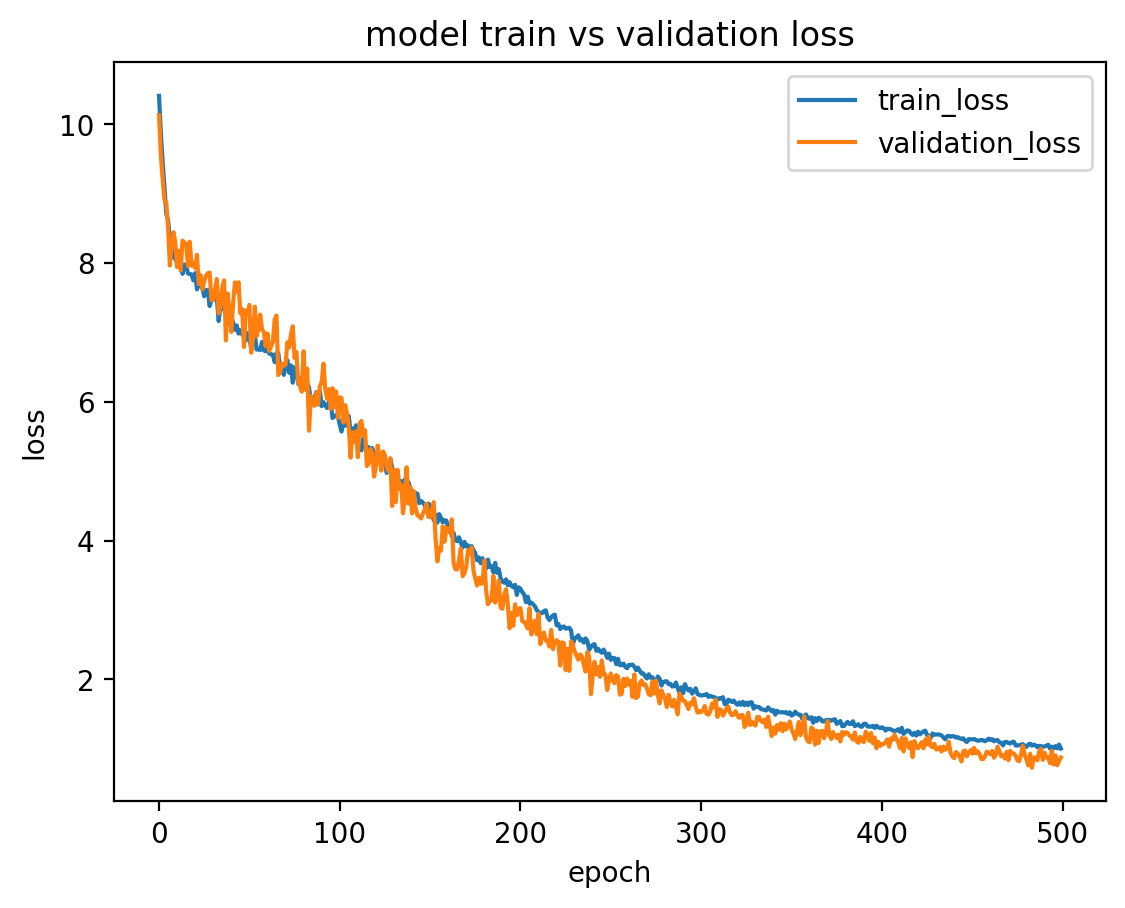

Result stored in /content/drive/MyDrive/5 - Music Generation by GPT/output/MuGenTransformer_v3_500321683977257_16v2f/


In [ ]:
epochs = 500
batchsize = 32
output_path = f"/content/drive/MyDrive/5 - Music Generation by GPT/output/MuGenTransformer_v3_{epochs}{batchsize}{int(time.time())}_16v2f/"


my_training_batch_generator = My_Custom_Generator(all_song_tokenised, batchsize, sequence_length)
my_validation_batch_generator = My_Custom_Generator(all_song_tokenised, batchsize, sequence_length, val_split=0.1)


# if not os.path.exists(output_path):
#     os.mkdir(output_path)

# model.load_weights("./output/train_multilabel_v3_1_4001000_16th/music-gen-weight.hdf5")

weight_path = output_path + "music-gen-weight.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    weight_path,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint,gen_callback]
# history = model.fit(network_input,
#                     network_output, 
#                     epochs=epochs, 
#                     batch_size=batchsize, 
#                     callbacks=callbacks_list,
#                     validation_split=0.1,
#                    shuffle=True)

history = model.fit(x = my_training_batch_generator,
                    callbacks = callbacks_list,                    
                   epochs = epochs,
                   verbose = 1,
                   validation_data = my_validation_batch_generator)

train_loss += history.history['loss']
val_loss += history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper right')
plt.savefig(output_path + 'loss.png')
plt.show()
print("Result stored in {}".format(output_path))

## Inference
Get a random seq from a random song from input. 
Then predict from it

In [ ]:
seed_len = 100
num_note_to_gen = 1000

song_idx = random.randint(0,len(all_song_tokenised)-1)
seq_start_at = random.randint(0,len(all_song_tokenised[song_idx])-sequence_length)   
start_tokens = all_song_tokenised[song_idx][seq_start_at:seq_start_at + seed_len].tolist()
# start_tokens = inf_song[:seed_len]
while (start_tokens == [()]*sequence_length):
    print("Got all zeros, rerolling")
    song_idx = random.randint(0,len(all_song_tokenised)-1)
    seq_start_at = random.randint(0,len(all_song_tokenised[song_idx])-sequence_length)   
    start_tokens = all_song_tokenised[song_idx][seq_start_at:seq_start_at + sequence_length].tolist()
    
ori = start_tokens.copy()
backup = ori.copy()
# start_tokens = 


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sample_from(logits, k):
    logits, indices = tf.math.top_k(logits, k= k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = np.asarray(logits).astype("float32")
    if(unk_tag_idx in indices):
        unk_tag_position = np.where(indices == unk_tag_idx)[0].item()
        indices = np.delete(indices, unk_tag_position)
        preds = np.delete(preds, unk_tag_position)
    preds = softmax(preds)
#     while out == 0:
#         print(f"predicted <UNK> tag with probability {preds[np.where(indices==0)[0][0]]}")
#         out = np.random.choice(indices, p=preds)
    return np.random.choice(indices, p=preds)

def convertToRoll(seq_list):
#     a = network_input[start_idx].tolist()
    seq_list = [int_to_combi[i] for i in seq_list]
    roll = mlb.transform(seq_list)
    print(seq_list)
    return roll


k = 10
tokens_generated = []
num_tokens_generated = 0

while num_tokens_generated <= num_note_to_gen:

    x = start_tokens[-sequence_length:]
    pad_len = maxlen - len(start_tokens)
    sample_index = -1
    if pad_len > 0:
        x = start_tokens + [0] * pad_len
        sample_index = len(start_tokens) - 1
    
    x = np.array([x])
    y, _ = model.predict(x)
    sample_token = sample_from(y[0][sample_index], 10)
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
    print(f"generated {num_tokens_generated} notes")
    
# print(f"Piano int seq generated")
piano_roll = convertToRoll(start_tokens)
print("-------------------------------------------")
ori = convertToRoll(ori)


1/1 [==============================] - 0s 28ms/step
generated 1 notes
1/1 [==============================] - 0s 26ms/step
generated 2 notes
1/1 [==============================] - 0s 30ms/step
generated 3 notes
1/1 [==============================] - 0s 37ms/step
generated 4 notes
1/1 [==============================] - 0s 28ms/step
generated 5 notes
1/1 [==============================] - 0s 30ms/step
generated 6 notes
1/1 [==============================] - 0s 27ms/step
generated 7 notes
1/1 [==============================] - 0s 29ms/step
generated 8 notes
1/1 [==============================] - 0s 33ms/step
generated 9 notes
1/1 [==============================] - 0s 28ms/step
generated 10 notes
1/1 [==============================] - 0s 29ms/step
generated 11 notes
1/1 [==============================] - 0s 26ms/step
generated 12 notes
1/1 [==============================] - 0s 30ms/step
generated 13 notes
1/1 [==============================] - 0s 28ms/step
generated 14 notes
1/1 [==========

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['<', '>', 'K', 'N', 'U'] will be ignored
  warnings.warn(


In [ ]:
def piano_roll_to_pretty_midi(piano_roll_in, fs, program=0, velocity = 64):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    piano_roll = np.where(piano_roll_in == 1, 64, 0)
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI(initial_tempo=100.0)
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    print(piano_roll.shape)
    
    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


## Export as MIDI
Save the inference result to output folder

In [ ]:
bpm = 150
fs = 1/((60/bpm)/4)
name = "random2"
# fs = 100
# ori = np.array(ori)
mid_out = piano_roll_to_pretty_midi(piano_roll.T, fs=fs)
mid_ori = piano_roll_to_pretty_midi(ori.T, fs=fs)
midi_out_path = output_path+f"gpt-v3-id-{name}.mid"
if midi_out_path is not None:
        mid_out.write(midi_out_path)
        
midi_ori_path = output_path+f"ori-gpt-v3-id-{name}.mid"
if midi_ori_path is not None:
        mid_ori.write(midi_ori_path)

(128, 1103)
(128, 102)


Save full length of seed song for reference.

In [ ]:
# ori_full = all_song_tokenised[song_idx][seq_start_at:].tolist()
ori_full = inf_song[:sequence_length+1000]
ori_full = convertToRoll(ori_full)
ori_full = piano_roll_to_pretty_midi(ori_full.T, fs=fs)
midi_ori_full_path = output_path+f"orifull-gpt-v3-{name}.mid"
if midi_ori_full_path is not None:
        ori_full.write(midi_ori_full_path)

NameError: ignored